In [1]:
from ipywidgets import interact
from fastai.basics import *

### Manual Parameter Tuning

At its core, deep learning seeks to produce a mathematical function that most closely approximates the values we expect in a given situation.

For example, we can construct a quadratic function with known parameters a,b,c and plot it, then make another quadratic starting with random values for parameters a,b,c and blindly tinker with their values until you hit the closest match. You can do this visually or with a loss function which tells us how close we are, mean squared error in this case.


In [35]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def make_quadratic(params: Tensor):
    return partial(quadratic, params=params)


def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()


original_params = torch.tensor([3.0, 2.0, 1.0])
quad = make_quadratic(params=original_params)

times = torch.arange(-10, 10).float()


@interact(a=1.1, b=1.1, c=1.1)
def plot_quadratic(a: float, b: float, c: float):
    plt.figure()
    plt.plot(times, quad(times))
    tinker_quad = make_quadratic(params=torch.tensor([a, b, c]))
    plt.title(
        f"MSE {round(mean_squared_error(quad(times), tinker_quad(times)).item(), 2)}"
    )
    plt.plot(times, tinker_quad(times))


interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

### Automated Parameter Tuning

This is basically what a deep learning model does, except we systematize the guesses to do it extremely quickly. We can use gradients to determine which direction, and relatively how much, we should move each parameter.

Here, we create a set of random initial training parameters with gradient calculation enabled. Then, we go through the training cycle:

1. Calculate the prediction based on our params
2. Calculate the loss on this prediction
3. Calculate the gradients on these parameters
4. Adjust our parameters based on the gardients times the learning rate
5. Repeat


tensor(2558.5718, grad_fn=<MeanBackward0>)
tensor(21.5210, grad_fn=<MeanBackward0>)
tensor(8.5803, grad_fn=<MeanBackward0>)
tensor(4.9863, grad_fn=<MeanBackward0>)
tensor(3.9549, grad_fn=<MeanBackward0>)
tensor(3.6265, grad_fn=<MeanBackward0>)
tensor(3.4917, grad_fn=<MeanBackward0>)
tensor(3.4107, grad_fn=<MeanBackward0>)
tensor(3.3453, grad_fn=<MeanBackward0>)
tensor(3.2848, grad_fn=<MeanBackward0>)


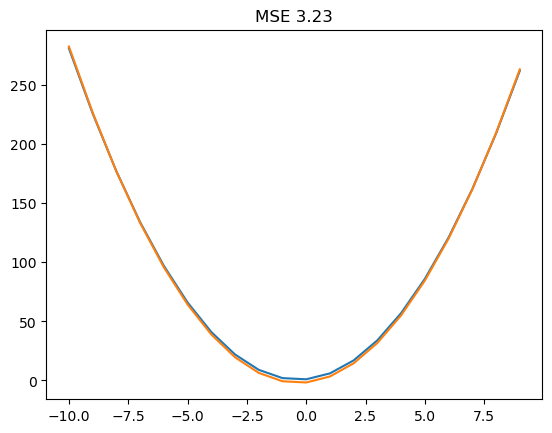

In [17]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def mean_squared_error(actual: Tensor, prediction: Tensor):
    return ((prediction - actual) ** 2).mean()


times = torch.arange(-10, 10).float()

actual_params = torch.tensor([3.0, 2.0, 1.0])
actual = quadratic(times, actual_params)
training_params = torch.randn(3, requires_grad=True)

learning_rate = 0.0001

for i in range(1000):
    prediction = quadratic(times, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 100 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(times, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
# Note these will be so close together they may be overlapping/second invisble
plt.plot(times, prediction.detach().numpy())


### Calculating Gradients

The last piece to understand here is how we calculate the gradients.

The gradients are based on the **derivative of the loss function with respect to each variable**.

To calculate the derivative of a multivariate function, we take the partial derivative of the loss function for each variable, holding the remainder constant.

Below is an example of getting the derivative of the loss function with respect to a, holding b and c constant. Note that the quadratic function and the loss function both appear the same on a graph because they are both quadratic formulae, but they are separate graphs. The function has x of time and y of speed, while the loss function has x of paramater value and y of loss.

Here we are getting every loss within a range of values of the paramater a, then plotting the minimum.

Ultimately, all the gradient is doing is taking the partial derivative with respect to each variable, holding the others constant. It tells you which way to move each and approximately how much based on this.


Text(0.5, 1.0, 'Loss function with min loss at: (3, 0.0)')

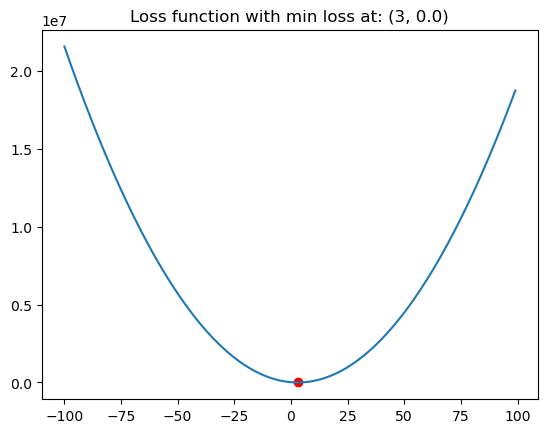

In [5]:
times = torch.arange(-10, 10).float()


def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def mean_squared_error(actual: Tensor, training_params: Tensor):
    prediction = quadratic(times, training_params)
    return ((prediction - actual) ** 2).mean()


actual_params = torch.tensor([3.0, 2.0, 1.0])
actual = quadratic(times, actual_params)

times = torch.arange(-10, 10).float()

learning_rate = 0.0001

losses = []

parameter_a_tests = range(-100, 100)

for parameter_a in parameter_a_tests:
    losses.append(
        mean_squared_error(actual, torch.tensor([float(parameter_a), 2.0, 1.0]))
    )

min_loss_idx = np.argmin(losses)

plt.figure()
plt.plot(parameter_a_tests, losses)
plt.scatter(parameter_a_tests[min_loss_idx], losses[min_loss_idx], color="red")
plt.plot()
plt.title(
    f"Loss function with min loss at: {parameter_a_tests[min_loss_idx], losses[min_loss_idx].item()}"
)


### Rectified Linear Units

A rectified linear unit is very simply just taking a linear function and clamping the negative values to zero.


In [20]:
def rectified_linear(x: Tensor, params: Tensor):
    m, b = params
    y = m * x + b
    # aka clamp clamp < 0 to 0
    return torch.clip(y, 0.0)


x = torch.linspace(-2.1, 2.1, 100)


@interact(m=1.5, b=1.5)
def plot_rectified_linear(m: float, b: float):
    plt.figure()
    plt.plot(x, rectified_linear(x, torch.tensor([m, b])))
    plt.title(f"Rectified Linear")


interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Rectified linear units are useful, as opposted to plain linear functions, because they can be meaningfully combined.

**If you just combine two linear functions, the result will always be another linear function.** So, if you are estimating anything except linear functions, this isn't useful.

However, if you combine rectified linear units, you can chain them together to produce different shapes.


In [29]:
def double_rectified_linear(x: Tensor, params: Tensor):
    m1, b1, m2, b2 = params
    y1 = torch.clip(m1 * x + b1, 0)
    y2 = torch.clip(m2 * x + b2, 0)
    return y1 + y2


@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_rectified_linear(m1: float, b1: float, m2: float, b2: float):
    plt.figure()
    plt.plot(x, double_rectified_linear(x, torch.tensor([m1, b1, m2, b2])))
    plt.title(f"Double Rectified Linear")


interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

Despite being so simple, the beauty of combining rectified linear functions is that, with enough of them added together, **you could approximate any function with a single input, to whatever accuracy you like!** Any time a function doesn't quite match, just add a few more additions to the mix to make it a bit closer.


In [85]:
def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()


def quadruple_rectified_linear(x: Tensor, params: Tensor):
    m1, b1, m2, b2, m3, b3, m4, b4 = params
    y1 = torch.clip(m1 * x + b1, 0)
    y2 = torch.clip(m2 * x + b2, 0)
    y3 = torch.clip(m3 * x + b3, 0)
    y4 = torch.clip(m4 * x + b4, 0)
    return y1 + y2 + y3 + y4


@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=1.1, b3=1.1, m4=-0.2, b4=-0.2)
def plot_quadruple_rectified_linear(
    m1: float,
    b1: float,
    m2: float,
    b2: float,
    m3: float,
    b3: float,
    m4: float,
    b4: float,
):
    plt.figure()
    quad_relu = quadruple_rectified_linear(
        x, torch.tensor([m1, b1, m2, b2, m3, b3, m4, b4])
    )
    plt.plot(x, quad_relu)
    quad = quadratic(x, torch.tensor([3, 2, 1]))
    plt.plot(x, quad)
    plt.title(
        f"Quadruple Rectified Linear\nApproximating Quadratic\nMean Squared Error: {mean_squared_error(quad, quad_relu)}"
    )


interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

tensor(44.4703, grad_fn=<MeanBackward0>)
tensor(0.7804, grad_fn=<MeanBackward0>)
tensor(0.5327, grad_fn=<MeanBackward0>)
tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.4576, grad_fn=<MeanBackward0>)
tensor(0.4461, grad_fn=<MeanBackward0>)
tensor(0.4407, grad_fn=<MeanBackward0>)
tensor(0.4372, grad_fn=<MeanBackward0>)
tensor(0.4345, grad_fn=<MeanBackward0>)
tensor(0.4322, grad_fn=<MeanBackward0>)


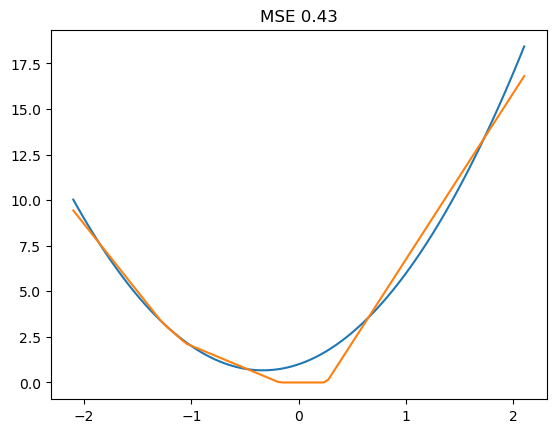

In [43]:
actual = quadratic(x, torch.tensor([3.0, 2.0, 1.0]))
training_params = torch.randn(8, requires_grad=True)

learning_rate = 0.001

for i in range(100000):
    prediction = quadruple_rectified_linear(x, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 10000 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(x, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
plt.plot(x, prediction.detach().numpy())


We could keep increasing the fidelity of our predictions by adding more rectified linears. If we go up to something like a 40-layered rectified linear, we can predict a **quadratic** equation within a small percentage using **rectified linear** equations layered together.


In [4]:
from itertools import islice
from typing import Iterable, Any

# https://docs.python.org/3/library/itertools.html#itertools.zip_longest
def grouper(iterable, n, *, incomplete="fill", fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == "fill":
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == "strict":
        return zip(*args, strict=True)
    if incomplete == "ignore":
        return zip(*args)
    else:
        raise ValueError("Expected fill, strict, or ignore")


def n_rectified_linear(x: Tensor, params: Tensor):
    rectified_linears = [
        torch.clip(linear_params[0] * x + linear_params[1], 0)
        for linear_params in grouper(params, 2, incomplete="ignore")
    ]
    return reduce(add, rectified_linears)


actual = quadratic(x, torch.tensor([3.0, 2.0, 1.0]))
training_params = torch.randn(80, requires_grad=True)

learning_rate = 0.001

for i in range(10000):
    prediction = n_rectified_linear(x, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 1000 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(x, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
plt.plot(x, prediction.detach().numpy())


NameError: name 'quadratic' is not defined

We were already able to perfectly predict a quadratic equation by manipulating the inputs of the quadratic from unknowns, so how is this helpful?

That is of limited use because we substantially limited the universe of possibilities - we already made the assumption it was a quadratic, we just needed the parameters. If we had instead been predicting a sine wave, the quadratic input manipulation would have been useless.

The beauty of combining rectified linear units is that it is **universally applicable**. The shape of the curve doesn't matter, we can predict anything with enough rectified linears.


In [206]:
import torch.nn as nn
from typing import Callable

def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()

def n_rectified_linear(x: Tensor, params: Tensor):
    rectified_linears = [
        torch.clip(linear_params[0] * x + linear_params[1], 0)
        for linear_params in grouper(params, 2, incomplete="ignore")
    ]
    return reduce(add, rectified_linears)

def train_model(
    input: Tensor,
    labels: Tensor,
    loss_function: Callable[[Tensor, Tensor], Tensor],
    learning_rate: float = 0.0001,
    epochs: int = 1000
):
    training_params = torch.randn(90, requires_grad=True)

    for i in range(epochs):
        prediction = n_rectified_linear(input, training_params)
        # loss = mean_squared_error(labels, prediction)
        loss = loss_function(labels, prediction)
        if i % 100 == 0 or i == 0:
            print(loss)
            # plt.title(f"MSE {round(loss.item(), 3)}")
            # plt.plot(x, actual)
            # plt.plot(x, prediction.detach().numpy())
            # plt.pause(0.01)
        # if i % 1000 == 0:
        #     learning_rate = learning_rate / 1.5
        loss.backward()  # AKA calculate gradient
        training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
        # Note grad has to be reset or it accumulates between cycles and produces incorrect data
        training_params.grad = None

    return prediction


tensor(6251.5776, grad_fn=<MeanBackward0>)
tensor(671.9824, grad_fn=<MeanBackward0>)
tensor(767.6995, grad_fn=<MeanBackward0>)
tensor(559.4589, grad_fn=<MeanBackward0>)
tensor(526.4018, grad_fn=<MeanBackward0>)
tensor(550.9539, grad_fn=<MeanBackward0>)
tensor(490.5375, grad_fn=<MeanBackward0>)
tensor(486.2121, grad_fn=<MeanBackward0>)
tensor(527.5562, grad_fn=<MeanBackward0>)
tensor(503.6173, grad_fn=<MeanBackward0>)


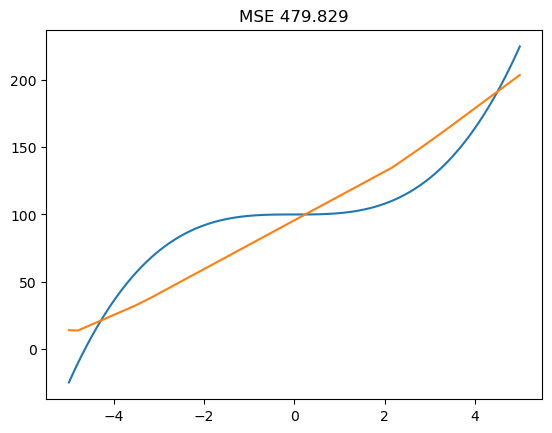

In [208]:
x = torch.linspace(-5, 5, 100)
# actual = torch.sigmoid(x)
# actual = torch.sin(x)
# actual = quadratic(x, torch.tensor([-3.0, 2.0, 1.0])) + 100
actual = x**3 + 100

loss_function = mean_squared_error
prediction = train_model(x, actual, mean_squared_error, 0.01, 1000)
# prediction = train_model(x, actual, loss_function, 0.01, 1000)

plt.plot(x, actual)
plt.title(f"MSE {round(loss_function(actual, prediction).item(), 3)}")
plt.plot(x, prediction.detach().numpy())

Rectified linears seem incapable of bending downward, so they can't approximate anything with downward turns, it can only go varying degrees of down to up. The original quadratic was an upward curve so it worked perfectly for that. I think the metaphor breaks down here.
